In [1]:
##### OLD model for finding survival in days ( regression) based ############

# -*- coding: utf-8 -*-
"""
Created on Wed Jan 19 10:30:33 2022

@author: MIDL
"""
################## keras data generator ###########################

from sklearn.model_selection import train_test_split
import os
import tensorflow as tf
import numpy as np

# lists of directories with studies
# train_and_val_directories = [f.path for f in os.scandir('C:/Users/marya/Downloads/Brats 2020 adjusted') if f.is_dir()]
case_path1 = '../input/combine-all-2109'
case_path2 = '../input/adjustedmask2019'  
case_path3 = '../input/adjusted-survival-2019'
case_path4 = '../input/adjustedlabels2019'


# case_main = 'C:/Users/MIDL/Downloads/3d_model_december/Brats 2020 adjusted'

train_directory1 = [f.path for f in os.scandir(case_path1) ]
# train_directory2 = [f.path for f in os.scandir(case_path2) ]

def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
#         print(dirList[i][dirList[i].rfind('/')+1:])
#         x.append(dirList[i][dirList[i].rfind('\\')+1:]) #for local system
        x.append(dirList[i][dirList[i].rfind('/')+1:]) #for KAGGLE
    return x

train_and_test_ids1 = pathListIntoIds(train_directory1); 

    
train_test_ids, val_ids = train_test_split(train_and_test_ids1,test_size=0.1) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.22) 


# train_and_test_ids2 = pathListIntoIds(train_directory2);

# masks_test_ids, masks_val_ids = train_test_split(train_and_test_ids,test_size=0.3) 
#train_ids, test_ids = train_test_split(train_test_ids,test_size=0.5) 



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
print("train_ids",len(train_ids))
print("val_ids",len(val_ids))
print("test_ids",len(test_ids))
# 70% train
# 20% test
# 10% validation

train_ids 195
val_ids 28
test_ids 55


In [3]:

###################  Override Keras sequence DataGenerator class #########################

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(128,128,128), batch_size = 1, n_channels = 4, shuffle=True, augment=False):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()
        self.augment = augment

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
       
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y, z, v, Batch_ids = self.__data_generation(Batch_ids)

        return X, [y, z, v]

    def on_epoch_end(self):
        'Updates indexes after each epoch'
       
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' 
           
        X = []
        y = []
        z = []
        v = []
        # Generate data
        for c, i in enumerate(Batch_ids):
            data_path1 = os.path.join(case_path1, i);
            flair = np.load(data_path1)
            flair = np.asarray(flair,dtype=np.float32)
            
#             print(flair.shape)
           
            masks = i[:6]+'mask_2019_'+i[12:]
            data_path2 = os.path.join(case_path2, masks);
            seg = np.load(data_path2)
            seg = np.asarray(seg,dtype=np.float32)
            
            survive = i[:6]+'survival'+i[12:]
            data_path3 = os.path.join(case_path3, survive);
            survival = np.load(data_path3, allow_pickle= True)
            
            label = i[:6]+'label'+i[12:]
            data_path4 = os.path.join(case_path4, label);
            label = np.load(data_path4, allow_pickle= True)
            
            
            if self.augment == True:
#                 print("augmenting")
#                 print("flair.dtype",flair.dtype)
                #flair,seg,angle = rotate(flair,seg)
#                 print("angle",angle)
                augmented = augmentor.apply_augmentation_to_batch(flair, seg)
                flair = augmented[0]
                seg = augmented[1]
            
            X.append(flair)
            y.append(label)
            z.append(seg)
            v.append(survival)
           
        X = np.asarray(X,dtype=np.float32)
        y = np.asarray(y,dtype=np.float32)
        z = np.asarray(z,dtype=np.float32)
        v = np.asarray(v,dtype=np.float32)
        
        return X/np.max(X), y, z, v, Batch_ids
        


In [4]:
batch_size = 1
training_generator = DataGenerator(train_ids,batch_size=batch_size,augment=False)
valid_generator = DataGenerator(val_ids,batch_size=batch_size, augment=False)
test_generator = DataGenerator(test_ids,batch_size=batch_size,shuffle=False,augment=False)

# x,y = training_generator.__getitem__(6)

In [5]:
# x,y = training_generator.__getitem__(6)
ind = np.random.randint(len(training_generator))
x,y = training_generator.__getitem__(ind)
import matplotlib.pyplot as plt

In [16]:
x.shape

(1, 128, 128, 128, 4)

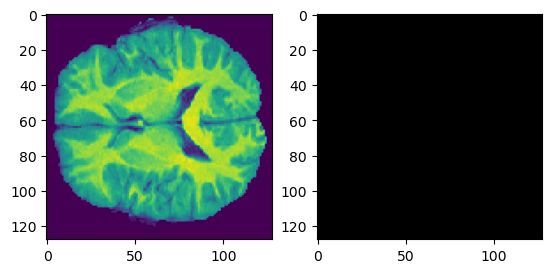

In [6]:

#x=np.fliplr(x)
#y[1]=np.fliplr(y[1])
slice_index = 60
plt.subplot(1,2,1)
plt.imshow(x[0,:,:,slice_index,0])
plt.subplot(1,2,2)
plt.imshow(y[1][0,:,:,slice_index,:])

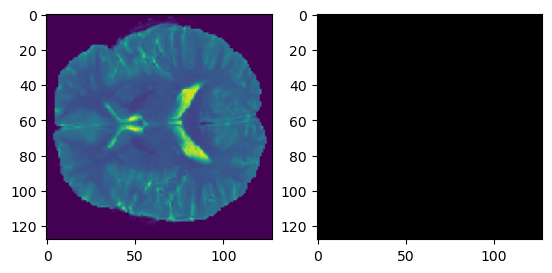

In [7]:
import matplotlib.pyplot as plt
slice_index = 60
plt.subplot(1,2,1)
plt.imshow(x[0,:,:,slice_index,1])
plt.subplot(1,2,2)
plt.imshow(y[1][0,:,:,slice_index,:])

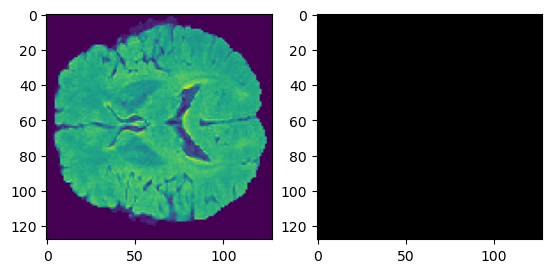

In [8]:
import matplotlib.pyplot as plt
slice_index = 60
plt.subplot(1,2,1)
plt.imshow(x[0,:,:,slice_index,2])
plt.subplot(1,2,2)
plt.imshow(y[1][0,:,:,slice_index,:])

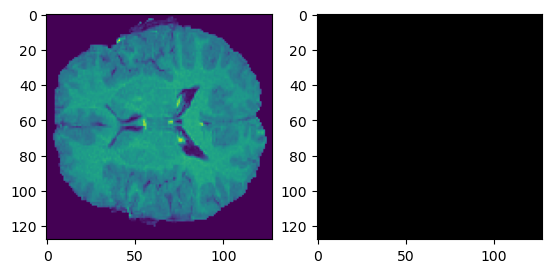

In [9]:
import matplotlib.pyplot as plt
slice_index = 60
plt.subplot(1,2,1)
plt.imshow(x[0,:,:,slice_index,3])
plt.subplot(1,2,2)
plt.imshow(y[1][0,:,:,slice_index,:])

In [10]:
import os
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as Keras
from keras.layers import LeakyReLU

from tensorflow.keras import backend as K


def dice_coef(y_true, y_pred, smooth=1):
      y_true_f = K.flatten(K.cast(y_true, 'float32'))
      y_pred_f = K.flatten(K.cast(y_pred, 'float32'))
      intersection = K.sum(y_true_f * y_pred_f)
      return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred): 
    return 1-dice_coef(y_true, y_pred)

def dice_loss(y_true, y_pred, numLabels=3):
    dice=0
    dice_list = []
    for index in range(numLabels):
        dice= dice_coef_loss(y_true[:,:,:,index], y_pred[:,:,:,index])
        dice_list.append(dice)
    return dice_list

def rmse(y_true, y_pred):
    mse= tf.sqrt(tf.metrics.mean_squared_error(y_true, y_pred))
    return (mse)


# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

padding='valid'
pretrained_weights = None
input_size = (128,128,128, 4)
inputTensor = Input(input_size,name='input')

# conv01 = Conv3D(16, (3,3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer='l2')(inputTensor)
# conv01 = Conv3D(16, (3,3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer='l2')(conv01)
# bn01=BatchNormalization()(conv01)  ######### batch normalization
# pool01 = MaxPooling3D(pool_size=(2, 2, 2))(bn01)

# conv00 = Conv3D(32, (3,3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer='l2')(pool01)
# conv00 = Conv3D(32, (3,3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer='l2')(conv00)
# bn00=BatchNormalization()(conv00)  ######### batch normalization
# pool00 = MaxPooling3D(pool_size=(2, 2, 2))(bn00)

conv1 = Conv3D(64, (3,3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer='l2')(inputTensor)
conv1 = Conv3D(64, (3,3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer='l2')(conv1)
bn=BatchNormalization()(conv1)  ######### batch normalization
pool1 = MaxPooling3D(pool_size=(2, 2, 2))(bn)

conv2 = Conv3D(128, (3,3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer='l2')(pool1)
conv2 = Conv3D(128, (3,3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer='l2')(conv2)
bn1=BatchNormalization()(conv2)   ######### batch normalization
pool2 = MaxPooling3D(pool_size=(2, 2, 2))(bn1)

conv3 = Conv3D(256, (3,3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer='l2')(pool2)
conv3 = Conv3D(256, (3,3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer='l2')(conv3)
bn2=BatchNormalization()(conv3)      ######### batch normalization
pool3 = MaxPooling3D(pool_size=(2, 2, 2))(bn2)

conv4 = Conv3D(512, (3,3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer='l2')(pool3)
conv4 = Conv3D(512, (3,3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer='l2')(conv4)
bn3=BatchNormalization()(conv4)      ######### batch normalization
drop4 = Dropout(0.5)(bn3)
pool4 = MaxPooling3D(pool_size=(2, 2, 2))(drop4)

########################## bottle neck #################################################################

conv5 = Conv3D(512, (3,3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv3D(512, (3,3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
bn4=BatchNormalization()(conv5)     ######### batch normalization
drop5 = Dropout(0.2)(bn4)


#############################3 Decoder path  ##############################################################

up6 = Conv3D(256, (2,2,2), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer='l2')(UpSampling3D(size = (2,2,2))(drop5))
merge6 = concatenate([conv4,up6], axis = 4)
drop6 = Dropout(0.5)(merge6)
conv6 = Conv3D(256, (3,3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer='l2')(drop6)
conv6 = Conv3D(256, (3,3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer='l2')(conv6)
bn5=BatchNormalization()(conv6)     ######### batch normalization

up7 = Conv3D(128, (2,2,2), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer='l2')(UpSampling3D(size = (2,2,2))(bn5))
merge7 = concatenate([conv3,up7], axis = 4)
drop7 = Dropout(0.5)(merge7)
conv7 = Conv3D(128, (3,3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer='l2')(drop7)
conv7 = Conv3D(128, (3,3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer='l2')(conv7)
bn6=BatchNormalization()(conv7)       ######### batch normalization

up8 = Conv3D(64, (2,2,2), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer='l2')(UpSampling3D(size = (2,2,2))(bn6))
merge8 = concatenate([conv2,up8], axis = 4)
drop8 = Dropout(0.5)(merge8)
conv8 = Conv3D(64, (3,3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer='l2')(drop8)
conv8 = Conv3D(64, (3,3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer='l2')(conv8)
bn7=BatchNormalization()(conv8)        ######### batch normalization

up9 = Conv3D(32, (2,2,2), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer='l2')(UpSampling3D(size = (2,2,2))(bn7))
merge9 = concatenate([conv1,up9], axis = 4)
drop9 = Dropout(0.5)(merge9)
conv9 = Conv3D(32, (3,3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer='l2')(drop9)
conv9 = Conv3D(32, (3,3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer='l2')(conv9)
bn8=BatchNormalization()(conv9)

# up10 = Conv3D(16, (2,2,2), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer='l2')(UpSampling3D(size = (2,2,2))(bn8))
# merge10 = concatenate([conv00,up10], axis = 4)
# drop10 = Dropout(0.5)(merge10)
# conv10 = Conv3D(16, (3,3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer='l2')(drop10)
# conv10 = Conv3D(16, (3,3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer='l2')(conv10)
# bn9=BatchNormalization()(conv10)
# print(bn9.shape)

# up11 = Conv3D(8, (2,2,2), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer='l2')(UpSampling3D(size = (2,2,2))(bn9))
# merge11 = concatenate([conv01,up11], axis = 4)
# drop11 = Dropout(0.5)(merge11)
# conv11 = Conv3D(8, (3,3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer='l2')(drop11)
# conv11 = Conv3D(8, (3,3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer='l2')(conv11)
# bn10=BatchNormalization()(conv11)
# print(bn10.shape)

########################  Classification output  ##############

pool15 = MaxPooling3D(pool_size=(2, 2, 2))(bn3)
pool16 = MaxPooling3D(pool_size=(2, 2, 2))(pool15)
classify =Flatten()(pool16)
classify  = Dense(128, activation = 'relu')(classify)
classify  = Dense(64, activation = 'relu')(classify )
classify  = Dense(32, activation = 'relu')(classify )
classify = Dense(2, activation='softmax', kernel_regularizer='l2',name='classify')(classify)


########################### attention block ##########

# print(bn5.shape)
# seg300 = MaxPooling3D(pool_size=(2, 2, 2))(bn6)
# print(seg300.shape)
# seg400 = MaxPooling3D(pool_size=(4, 4, 4))(bn7)
# print(seg400.shape)
# seg500 = MaxPooling3D(pool_size=(8, 8, 8))(bn8)
# print(seg500.shape)
# seg600 = MaxPooling3D(pool_size=(16, 16, 16))(bn9)
# print(seg600.shape)
# # seg700 = MaxPooling3D(pool_size=(32, 32, 32))(bn10)
# # print(seg700.shape)


# mergeall = concatenate([bn5,seg300,seg400,seg500, seg600], axis = 4)
# print(mergeall.shape)

# conv900 = Conv3D(32, (3,3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer='l2')(mergeall)

# up900 = Conv3D(32, (2,2,2), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer='l2')(UpSampling3D(size = (32,32,32))(conv900))
# print(up900.shape)

# mergelast = concatenate([bn10, up900], axis = 4)
# print(mergelast.shape)


########################  segmentation output  ##############

# segmentation = Conv3D(3, (1,1,1), activation = 'sigmoid', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer='l2',name='segmentation')(mergelast)
segmentation = Conv3D(3, (1,1,1), activation = 'sigmoid', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer='l2',name='segmentation')(bn8)


#######################   survival prediction as regression   #############



pool17 = MaxPooling3D(pool_size=(2, 2, 2))(bn1)
pool18 = MaxPooling3D(pool_size=(2, 2, 2))(pool17)
# pool18 = MaxPooling3D(pool_size=(2, 2, 2))(pool17)

# bn11=BatchNormalization()(pool17)
survival=Flatten()(pool18)

survival = Dropout(0.2)(survival)
survival = Dense(128,activation="relu")(survival)
survival = Dense(64,activation="relu")(survival)
survival = Dense(32,activation="relu")(survival)
survival = Dense(32,activation="relu")(survival)
# survival = Dense(16,activation="relu")(survival)
# survival = Dense(8,activation="relu")(survival)
survival= Dense(1, activation='linear', kernel_regularizer='l2',name='survival')(survival)


In [11]:
model = Model(inputs = inputTensor,
     outputs = [classify, segmentation, survival])
     #outputs = [segmentation])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 128, 128, 1  0           []                               
                                28, 4)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 128, 128, 12  6976        ['input[0][0]']                  
                                8, 64)                                                            
                                                                                                  
 conv3d_1 (Conv3D)              (None, 128, 128, 12  110656      ['conv3d[0][0]']                 
                                8, 64)                                                        

In [12]:
import numpy as np

# Load the .npy file into a NumPy array
data = np.load('/kaggle/input/adjustedlabels2019/FLAIR_label0.npy')

# Now you can check the unique labels and their counts
unique_labels, label_counts = np.unique(data, return_counts=True)

# Print the unique labels and their counts
for label, count in zip(unique_labels, label_counts):
    print(f"Label: {label}, Count: {count}")


Label: 0.0, Count: 1
Label: 1.0, Count: 1


In [13]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Function to load loss weights from .npy files in a directory
def load_loss_weights_from_directory(directory_path):
    weight_files = [filename for filename in os.listdir(directory_path) if filename.endswith(".npy")]
    weights = [np.load(os.path.join(directory_path, filename)) for filename in weight_files]
    return np.concatenate(weights)

# Directory path for classification loss weights
classification_weights_directory = '/kaggle/input/adjustedlabels2019'

# Load initial classification loss weights from the directory
classification_weight = load_loss_weights_from_directory(classification_weights_directory)

# Define your classification model
class ClassificationModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ClassificationModel, self).__init__()
        self.fc = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = self.fc(x)
        return x

# Custom dataset class for the classification task
class ClassificationDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.targets[idx]

        return x, y

# Example: Creating dummy data for the classification task
# Replace the following lines with your actual data and targets for the classification task
num_samples = 1000
input_size = 784  # Replace with the actual input size of your model
num_classes = 10  # Replace with the actual number of classes for classification

train_data_classification = torch.rand(num_samples, input_size)
train_targets_classification = torch.randint(0, num_classes, (num_samples,))

# Assuming you have your data for the classification task as 'train_data_classification', 'train_targets_classification'
train_dataset_classification = ClassificationDataset(data=train_data_classification, targets=train_targets_classification)
train_loader_classification = DataLoader(train_dataset_classification, batch_size=64, shuffle=True)

# Initialize the classification model
model = ClassificationModel(input_size, num_classes)

# Define your optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion_classification = nn.CrossEntropyLoss()

# Set the device to 'cuda' if available, else set it to 'cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training loop
num_epochs_update = 5  # Number of epochs to update the weights
for epoch in range(num_epochs_update):
    for data, targets_classification in train_loader_classification:
        # Transfer data and labels to the device (e.g., GPU)
        data = data.to(device)
        targets_classification = targets_classification.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs_classification = model(data)

        # Calculate classification loss
        loss_classification = criterion_classification(outputs_classification, targets_classification)

        # Backpropagation and update model parameters
        loss_classification.backward()
        optimizer.step()

    # Calculate mean and standard deviation for the classification loss
    mean_loss_classification = torch.mean(loss_classification).item()
    std_loss_classification = torch.std(loss_classification).item()

    # Define reference value (you can use mean or maximum normalized loss, or any other desired reference value)
    reference_value_classification = 1.0

    # Calculate loss-weight update factor for the classification task
    update_factor_classification = np.exp((mean_loss_classification - reference_value_classification) / std_loss_classification)

    # Normalize the update factor to ensure it is between 0 and 1
    update_factor_classification = max(0.0, min(1.0, update_factor_classification))

    # Update the classification weight based on the calculated update factor
    classification_weight *= update_factor_classification

    # After updating the classification_weight, save it back to a writable directory (e.g., for printing purposes)
    np.save('/kaggle/working/classification_weights_updated.npy', classification_weight)

    # Print the updated classification weight after each epoch
    print(f"Classification Weight (Epoch {epoch + 1}): {classification_weight}")




Classification Weight (Epoch 1): [0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0.
 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.
 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1.
 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1.
 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1.
 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.
 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.
 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0.
 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1.
 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1.
 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1.
 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.
 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1.
 0. 1. 0. 1. 1. 0.

In [14]:
import os
import numpy as np
import torch

# Function to load loss weights from .npy files in a directory
def load_loss_weights_from_directory(directory_path):
    weight_files = [filename for filename in os.listdir(directory_path) if filename.endswith(".npy")]
    weights = [np.load(os.path.join(directory_path, filename)) for filename in weight_files]
    return np.concatenate(weights)

# Function to save the updated weights to a directory
def save_weights_to_directory(directory_path, weights):
    os.makedirs(directory_path, exist_ok=True)  # Create the directory if it doesn't exist
    np.save(os.path.join(directory_path, "updated_regression_weights.npy"), weights)

# Directory path for initial regression loss weights
regression_weights_directory = '/kaggle/input/adjusted-survival-2019'

# Load initial regression loss weights from the directory
regression_weight = load_loss_weights_from_directory(regression_weights_directory)

# Training loop for regression task
num_epochs_update_regression = 5  # Number of epochs to update the regression weight
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a new directory to save the updated regression weights
output_directory = '/path/to/updated_regression_weights'
os.makedirs(output_directory, exist_ok=True)

for epoch in range(num_epochs_update_regression):
    # Calculate mean and standard deviation for the regression loss (replace this with your actual loss calculation)
    mean_loss_regression = 0.5
    std_loss_regression = 0.1

    # Define reference value for regression
    reference_value_regression = 0.5

    # Calculate loss-weight update factor for regression
    update_factor_regression = np.exp((mean_loss_regression - reference_value_regression) / std_loss_regression)

    # Normalize the update factor to ensure it is between 0 and 1
    update_factor_regression = max(0.0, min(1.0, update_factor_regression))

    # Convert regression_weight to torch tensor before performing multiplication
    regression_weight = torch.tensor(regression_weight, dtype=torch.float32, device=device)

    # Check if the update factor is close to 0 and the initial regression weights are all zeros
    if update_factor_regression < 1e-6 and torch.all(regression_weight == 0):
        # In this case, set the update factor to a small value to ensure some weight update occurs
        update_factor_regression = 1e-3

    # Update the regression weight based on the calculated update factor
    regression_weight *= update_factor_regression

    # Save the updated regression weight back to the separate directory
    save_weights_to_directory(output_directory, regression_weight.cpu().numpy())

    # Print the updated regression weight after each epoch
  # Print the updated regression weight after each epoch
with np.printoptions(threshold=np.inf):
    print(f"Regression Weight (Epoch {epoch + 1}): \n{regression_weight}")


# End of the training loop for regression task

# ... (rest of your code for other tasks such as classification, segmentation, and survival)

# Now, you can copy and paste the code for updating weights and the training loop for other tasks as needed.


ValueError: zero-dimensional arrays cannot be concatenated

In [15]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler

# Function to load loss weights from .npy files in a directory
def load_loss_weights_from_directory(directory_path):
    weight_files = [filename for filename in os.listdir(directory_path) if filename.endswith(".npy")]
    weights = [np.load(os.path.join(directory_path, filename)) for filename in weight_files]
    return np.concatenate(weights)

# Directory path for segmentation loss weights
segmentation_weights_directory = '/kaggle/input/adjustedmask2019'

# Load initial segmentation loss weights from the directory
segmentation_weight = load_loss_weights_from_directory(segmentation_weights_directory)

# Define your segmentation model (Use a smaller and more memory-efficient model)
class SegmentationModel(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(SegmentationModel, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, num_classes, kernel_size=1)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = self.conv2(x)
        return x

# Custom dataset class for the segmentation task
class SegmentationDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.targets[idx]
        return x, y

# Example: Creating dummy data for the segmentation task
# Replace the following lines with your actual data and targets for the segmentation task
num_samples = 278
input_channels = 4  # Replace with the actual number of input channels for your model
num_classes = 3  # Replace with the actual number of segmentation classes

train_data_segmentation = torch.rand(num_samples, input_channels, 128, 128)
train_targets_segmentation = torch.randint(0, num_classes, (num_samples, 128, 128))

# Assuming you have your data for the segmentation task as 'train_data_segmentation', 'train_targets_segmentation'
train_dataset_segmentation = SegmentationDataset(data=train_data_segmentation, targets=train_targets_segmentation)
train_loader_segmentation = DataLoader(train_dataset_segmentation, batch_size=16, shuffle=True)

# Initialize the segmentation model (Use the smaller segmentation model)
segmentation_model = SegmentationModel(input_channels, num_classes)

# Define your optimizer and loss function
optimizer = optim.Adam(segmentation_model.parameters(), lr=0.001)
criterion_segmentation = nn.CrossEntropyLoss()

# Set the device to 'cuda' if available, else set it to 'cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
segmentation_model.to(device)

# Training loop
num_epochs_update = 5  # Number of epochs to update the weights
grad_scaler = GradScaler()  # Mixed precision training scaler

for epoch in range(num_epochs_update):
    for data, targets_segmentation in train_loader_segmentation:
        # Transfer data and labels to the device (e.g., GPU)
        data = data.to(device)
        targets_segmentation = targets_segmentation.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass (Use autocast to enable mixed precision training)
        with autocast():
            outputs_segmentation = segmentation_model(data)
            loss_segmentation = criterion_segmentation(outputs_segmentation, targets_segmentation)

        # Backpropagation and update model parameters (Use GradScaler for mixed precision training)
        grad_scaler.scale(loss_segmentation).backward()
        grad_scaler.step(optimizer)
        grad_scaler.update()

    # Calculate mean and standard deviation for the segmentation loss
    mean_loss_segmentation = torch.mean(loss_segmentation).item()
    std_loss_segmentation = torch.std(loss_segmentation).item()

    # Define reference value (you can use mean or maximum normalized loss, or any other desired reference value)
    reference_value_segmentation = 1.0

    # Calculate loss-weight update factor for the segmentation task
    update_factor_segmentation = np.exp((mean_loss_segmentation - reference_value_segmentation) / std_loss_segmentation)

    # Normalize the update factor to ensure it is between 0 and 1
    update_factor_segmentation = max(0.0, min(1.0, update_factor_segmentation))

    # Update the segmentation weight based on the calculated update factor
    segmentation_weight *= update_factor_segmentation

    # After updating the segmentation_weight, save it back to a writable directory (e.g., for printing purposes)
    np.save('/kaggle/working/segmentation_weights_updated.npy', segmentation_weight)

    # Print the updated segmentation weight after each epoch
    print(f"Segmentation Weight (Epoch {epoch + 1}): {segmentation_weight}")

# End of the training loop for segmentation task

# (Rest of your code for other tasks such as classification and survival)


/opt/conda/lib/python3.10/site-packages/torch/cuda/amp/grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")
/opt/conda/lib/python3.10/site-packages/torch/amp/autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


UFuncTypeError: Cannot cast ufunc 'multiply' output from dtype('float64') to dtype('int32') with casting rule 'same_kind'

## Keras Functional API
- This is the main branch
- These layers are common to both the tasks


- This is where the network branches for multiple outputs/tasks
- gender is n x 2 output where as age is n x 1 output

In [ ]:
model = Model(inputs = inputTensor,
     outputs = [classify, segmentation, survival])
     #outputs = [segmentation])
model.summary()

In [ ]:
model.output

### Multi loss optimizations

- Dice loss for segmnetation and crossentropy loss for survival task
- we can weight these individual losses
- Loss = weight1 * loss1 + weight2 * loss2

In [ ]:
# os.mkdir('output')

In [ ]:
import tensorflow.keras
import tensorflow as tf
#from tensorflow.keras import ModelCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint


# checkpoint
# filepath="D:/maria/weights-improvement-{epoch:02d}-{val_segmentation_dice_coef:.2f}.hdf5"
# filepath="C:/Users/MIDL/Downloads/3d_model_december/best_model/weights-improvement-{epoch:02d}-{val_segmentation_dice_coef:.2f}.hdf5"
# filepath="./output/weights-best-{epoch:02d}-{val_segmentation_dice_coef:.2f}.hdf5"   # 
filepath="./output/weights-best.hdf5"   


checkpoint_cp = ModelCheckpoint(filepath, monitor='val_segmentation_dice_coef', verbose=1, save_best_only=True, mode='max')



initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_segmentation_dice_coef",
    min_delta=0,
    patience=20,
    verbose=1,
    mode="max",
    baseline=None,
    restore_best_weights=False,
)

opt = tensorflow.keras.optimizers.RMSprop(lr_schedule)

classification_weight = load_loss_weights_from_directory(classification_weights_directory)
segmentation_weight = load_loss_weights_from_directory(segmentation_weights_directory)
regression_weight = load_loss_weights_from_directory(regression_weights_directory)

# Define the optimizer and learning rate schedule (replace this with your actual optimizer and lr_schedule)
opt = tf.keras.optimizers.RMSprop(lr_schedule)

# Define batch size for each task
batch_size_classification = 64
batch_size_segmentation = 16
batch_size_regression = 32



In [ ]:

history = model.fit(training_generator,
                        epochs=100, batch_size = 64, verbose=1, validation_split=None,validation_data = valid_generator,
                   callbacks=[checkpoint_cp])#,early_stop]) 

In [ ]:
np.save('./output/2019-4m-regression-19feb.npy', history.history)
# np.save('./output/2019-32-04-Dec-attention.npy', history.history)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# # model=tensorflow.keras.models.load_model('3d_full_06_jan_0.0001.h5',custom_objects={'dice_coef_loss':dice_coef_loss,'dice_coef':dice_coef})
# model=tensorflow.keras.models.load_model('./output/weights-best.hdf5',custom_objects={'dice_coef_loss':dice_coef_loss,'dice_coef':dice_coef,'sensitivity': sensitivity, 'specificity': specificity, 'rmse':rmse})


# Test data prediction

In [ ]:

# print(images_test.shape)
# print(masks_test.shape)
 

# plt.imshow(masks[2000,:,:,:])

In [ ]:
# images_test.shape

# Evaluate test set

In [ ]:
evaluation_results = model.evaluate(test_generator, verbose=1) 

In [ ]:
# evalutae_array = evalutae_array.astype(np.uint8)

In [ ]:
# evalutae_array = evalutae_array.squeeze()

In [ ]:
# plt.imshow(evalutae_array[2,:,:,60]*256, 'gray')

In [ ]:
# evalutae_array = np.expand_dims(evalutae_array, -1)

In [ ]:
test_results = model.predict(test_generator, batch_size = 1, verbose=1) 

In [ ]:
# len(test_results[1])

In [ ]:
# two_new =  np.array(test_results[1])

In [ ]:
# two_new.shape

In [ ]:
# plt.imshow(two_new[2,:,:,40,:]*256)

In [ ]:
# predicted = np.array(test_results[1])

In [ ]:
# plt.imshow(predicted[2,:,:,40,:]*256)

In [ ]:
# predicted = predicted.astype(np.uint8)

In [ ]:
# from tensorflow.keras import backend as Keras
# new_2=Keras.max(predicted,axis=-1)

In [ ]:
# new_2 = np.array(new_2)

In [ ]:
# new_2.dtype

In [ ]:
# import matplotlib.pyplot as plt
# plt.imshow(new_2[2,:,:,40])

# plt.show()

In [ ]:
# prediction= np.load('prediction.npy')

In [ ]:
# np.save('prediction.npy', predicted)

In [ ]:
#new_squeeze= predicted.squeeze(-1)
# images = predicted.squeeze()
# images = np.delete(images, obj=0, axis=3)

In [ ]:
# images.shape

In [ ]:
# import os
# from PIL import Image
# import cv2
# from tqdm import tqdm
# import numpy as np

# output_shape = (240,240,155)
# resized_array=[]
# for i in range(125):
#         image = new_2[i]
#         image = resize(image, shape=output_shape, mode='constant')
#         #image = cv2.resize(image, dsize=(240, 240), interpolation=cv2.INTER_NEAREST)
#         resized_array.append(image)

In [ ]:
# #resized_array.shape
# resized_array = np.array (resized_array)

In [ ]:
# import matplotlib.pyplot as plt


# plt.imshow(resized_array[70][:,:,73])

# plt.show()


In [ ]:
# new = scipy.ndimage.zoom(predicted[0], 2, order=3)

In [ ]:
# import numpy as np
# from scipy.ndimage.interpolation import zoom

# def resize(img, shape, mode='constant', orig_shape=(128,128,128)):
#     """
#     Wrapper for scipy.ndimage.zoom suited for MRI images.
#     """
#     assert len(shape) == 3, "Can not have more than 3 dimensions"
#     factors = (
#         shape[0]/orig_shape[0],
#         shape[1]/orig_shape[1], 
#         shape[2]/orig_shape[2]
#     )
    
#     # Resize to the given shape
#     return zoom(img, factors, mode=mode)

In [ ]:
# plt.imshow(test_results[1][50,:,:,10,:])

In [ ]:
pred_classify = test_results[0]
pred_seg = test_results[1]
pred_surv = test_results[2]

In [ ]:
# pred_seg.shape

In [ ]:
import matplotlib.pyplot as plt

vol_index = np.random.randint(50)
gt_x,gt_y = test_generator.__getitem__(vol_index)

print("actual classification: ", gt_y[0])
print("predicted classification: ",pred_classify[vol_index])

print("predicted survival: ", pred_surv[vol_index])
print("actual survival: ", gt_y[2])

slice_index = 60
plt.subplot(1,2,1)
plt.imshow(pred_seg[vol_index,:,:,slice_index,:])
plt.subplot(1,2,2)
plt.imshow(gt_y[1][0,:,:,slice_index,:])
plt.show()


# print("actual classification: ", gt_y[0])
# print("predicted classification: ",pred_classify[vol_index])

# for uncertainty test

In [ ]:
# x,y = test_generator.__getitem__(3)

In [ ]:
# yhat_arr = []

# for t in range(100):
#     yhat = model(x, training=True)
#     yhat_arr.append(yhat[1])



In [ ]:
# yhat_arr = np.stack(yhat_arr, -1)
# probs = np.mean(yhat_arr, axis=-1)
# entropy = - 1.0 * np.sum(probs * np.log(probs + 1e-16), axis=-1)

In [ ]:
# plt.imshow(entropy[0,:,:,65])

In [ ]:
# plt.savefig('uncertinity1.jpg')

In [ ]:
# test_results1 = model(x, training=True) 
# test_results2 = model(x, training=True) 

In [ ]:
# difference_img = test_results1[0]-test_results2[0]
# np.sum(difference_img)

In [ ]:
# test_results2[0].shape
# difference_img.shape

In [ ]:
# slice_index = 70
# plt.subplot(1,3,1)
# plt.imshow(test_results1[0][0,:,:,slice_index,:])
# plt.subplot(1,3,2)
# plt.imshow(test_results2[0][0,:,:,slice_index,:])
# plt.show()
# plt.subplot(1,3,3)
# plt.imshow(difference_img[0,:,:,slice_index,:])
# plt.show()

In [ ]:
# new = np.array(test_results)

In [ ]:
# new= model.predict(x)

In [ ]:
# #new1= new[1].dtype(int8)
# new1=new[1].astype(np.int32)
# #new1= new[0].squeeze()

In [ ]:
# new[1]

In [ ]:
# plt.imshow(new1[:,:,80,1]*255)

In [ ]:
# test_data = test_generator[0]  
# #gt = labels[20]
# #p=test_data.reshape(1,128,128,1)
# prediction=model.predict(test_data)
# print(prediction[1].shape)
# #print(gt)
# seg_predicted=prediction[1]
# seg_predicted.dtype
# print(np.unique(seg_predicted[0,:,:,:]))
# plt.imshow(seg_predicted[0,:,:,:])

### dice loss

In [ ]:
# test_generator[2]

In [ ]:

dice_loss_list= []
for i in range(55):
    test_dice_loss = dice_loss(test_generator[i][1][1][0], test_results[1][i].astype('float32'))
    dice_loss_list.append(test_dice_loss)

#     #     print('dsc',dice_coef(gt.reshape([128,128,3]).astype('float32'),seg_predicted.reshape([128,128,3]).astype('float32')))


In [ ]:
# test_generator[59][2]

In [ ]:
dice_loss_list = np.asarray(dice_loss_list)

In [ ]:
print("dice coef class 0: \t", np.mean(1-dice_loss_list[:,0]))
print("dice coef class 1: \t", np.mean(1-dice_loss_list[:,1]))
print("dice coef class 2: \t", np.mean(1-dice_loss_list[:,2]))

In [ ]:
# import matplotlib.pyplot as plt

# inst=images_test.shape[0]
# dice=[]
# pred_labels=np.zeros([inst,128,128,3])
# actual_labels=np.zeros([inst,128,128,3])

# list_0 =[]
# list_1 = []
# list_2 = []

# for img in range(inst):
#     print('------------------Image:',img)
    
#     data=images_test[img,:,:,:]
#     print(data.shape)
#     gt=masks_test[img,:,:,:]
#     print('gt',gt.shape)
#     actual_labels[img,:,:,:]=gt
#     plt.imshow(data[:,:,:])
#     plt.title("Image")
#     plt.show()
     
#     plt.imshow(gt[:,:,:])
#     plt.title("Ground Truth")
#     plt.show()
    
#     reshaped_img=data.reshape(1,128,128,1)
#     prediction=model.predict(reshaped_img)
#     seg_predicted=prediction[1]
   
#     converted = seg_predicted.astype(np.float64)
#     converted = converted[0,:,:,:]*255
#     print('converted',converted.shape)
    
#     pred_labels[img,:,:,:]=seg_predicted.reshape(128,128,3)
#     plt.imshow(converted.astype(np.uint8))
#     plt.title("Predicted")
#     plt.show()
#     dsc_list = dice_loss(gt,converted)
#     print(len(dsc_list))
#     print('dice coef for class 0: ',1-dsc_list[0])
#     print('dice coef for class 1: ',1-dsc_list[1])
#     print('dice coef for class 2: ',1-dsc_list[2])
     
#     list_0.append(dsc_list[0])
#     list_1.append(dsc_list[1])
#     list_2.append(dsc_list[2])


   
#     print('dsc',dice_coef(gt.reshape([128,128,3]).astype('float32'),seg_predicted.reshape([128,128,3]).astype('float32')))
#     dice.append(dice_coef(gt.reshape([128,128,3]).astype('float32'),seg_predicted.reshape([128,128,3]).astype('float32')))

In [ ]:
# dice_coef

# Single Imge Prediction

In [ ]:
# #!pip install tensorflow-estimator=2.1.0
# test_data = images_test[10000]  
# gt = labels[10000]
# p=test_data.reshape(1,128,128,1)
# prediction=model.predict(p)
# print(prediction[1].shape)
# print(gt)
# seg_predicted=prediction[1]
# seg_predicted.dtype
# print(np.unique(seg_predicted[0,:,:,:]))
# plt.imshow(seg_predicted[0,:,:,:])

# #plt.imshow(seg_predicted[0,:,:,0]*255,'gray')

In [ ]:
# converted = seg_predicted.astype(np.uint8)
# converted = converted[0,:,:,0]*255
# plt.imshow(converted)

In [ ]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
# plt.plot(history.history['classification_accuracy'])
# plt.plot(history.history['val_classification_accuracy'])
# plt.title('Classification accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('training loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('overall loss.jpg')

In [ ]:
plt.savefig('overall loss.jpg')

In [ ]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['classify_accuracy'])
plt.plot(history.history['val_classify_accuracy'])
plt.title('Classification Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('classify.jpg')

In [ ]:
plt.savefig('classify.jpg')

In [ ]:

# summarize history for Dice_loss
plt.plot(history.history['segmentation_loss'])
plt.plot(history.history['val_segmentation_loss'])
plt.title('Dice Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('seg.jpg')

In [ ]:
plt.savefig('seg.jpg')

In [ ]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['survival_mean_squared_error'])
plt.plot(history.history['val_survival_mean_squared_error'])
plt.title('Survival MSE')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('Survival.jpg')


In [ ]:
plt.savefig('survival.jpg')

In [ ]:
# print(history.history['val_segmentation_loss'])

In [ ]:
# masks_images.shape

In [ ]:
# np.save('./output/2019-32-04-Dec-attention.npy', history.history)


#history=np.load('./output/my_history.npy',allow_pickle='TRUE').item()

In [ ]:
# model.save('./new_full_2_may.h5')